In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math

In [2]:
import importlib
import LearningCutsUtils.LearningCutsUtils
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
importlib.reload(LearningCutsUtils.LearningCutsUtils)
import LearningCutsUtils.LearningCutsUtils as LCU
from LearningCutsUtils.LearningCutsUtils import getBack, ListToGraph, OneToOneLinear, OneToOneLinearActivation, EfficiencyScanNetwork
from LearningCutsUtils.LearningCutsUtils import loss_fn
from LearningCutsUtils.LearningCutsUtils import effic_loss_fn

In [3]:
N=20000 # number of points
m=10 # dimensions

In [4]:
# array of means and widths for gaussians,
# indices are:
# - number of dimensions
# - signal (0) vs background (1)
# - mean (0) vs width (1)
np.random.seed(123)

# if we want more control over the function, for example
means_widths=[[[4,0.4],
               [-2,.10]],
              [[3,1.0],
               [-1,0.5]]]

means_widths=np.random.randn(m,2,2)               
width_scale_factor=2.
mean_scale_factor=2.

# now construct the training data.  after taking transpose, should be N rows by m columns.  
x_signal=np.array([means_widths[i][0][0]+width_scale_factor*np.fabs(means_widths[i][0][1])*np.random.randn(N) for i in range(m)]).T
y_signal=np.ones(N)
x_backgr=np.array([means_widths[i][1][0]+width_scale_factor*np.fabs(means_widths[i][1][1])*np.random.randn(N) for i in range(m)]).T
y_backgr=np.zeros(N)
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

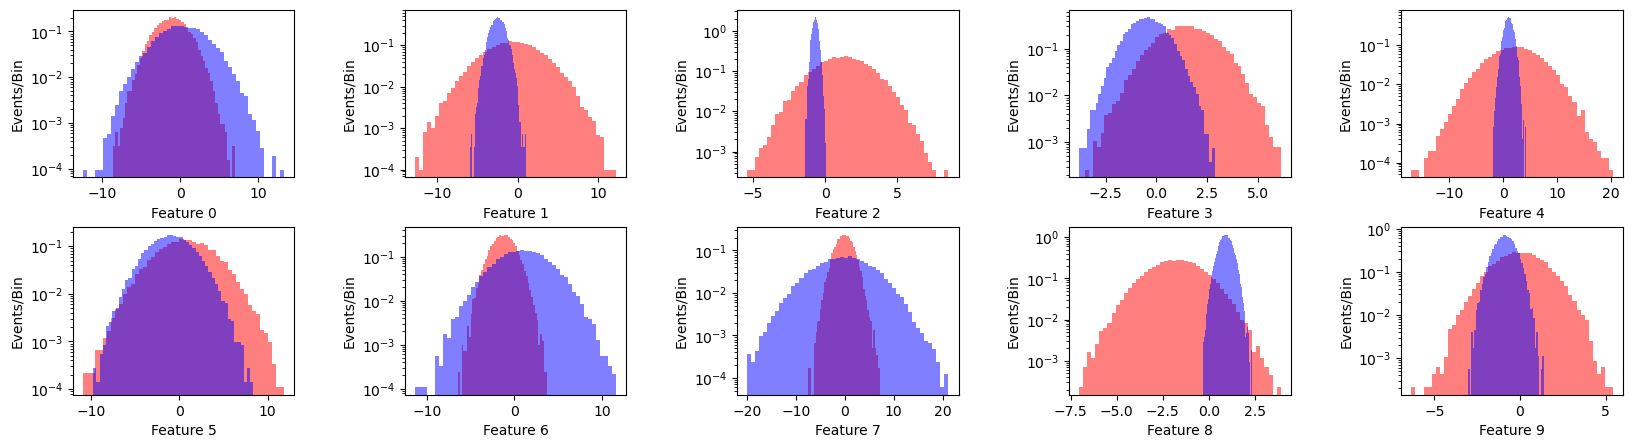

In [5]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [7]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

In [8]:
gt=1.
lt=-1.
cuts_gt_lt = [lt, gt, gt, gt, lt,
              gt, lt, lt, lt, gt]

In [17]:
# some hyperparameters
torch.manual_seed(123)
activation_input_scale_factor=4.
learning_rate=0.02
batch_size=int(len(y_train)/20.) # one batch
epochs=100
alpha=10.   # scaling factor to tune how important hitting the target signal efficiency is
beta=10.    # scaling factor to tune how important background rejection is
gamma=1e-3 # scaling factor for how aggressively to push the cuts to zero
target_efficiency = 0.8

In [18]:
net = torch.nn.Sequential(
    OneToOneLinear(m,cuts_gt_lt),
    OneToOneLinearActivation(activation_input_scale_factor)
)
torch.save(net.state_dict(), 'net_learningbiases.pth')
#optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
{n: theta.shape for n, theta in net.named_parameters()}

{'0.bias': torch.Size([10])}

In [19]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_learningbiases.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss, s_eff, b_eff, effloss, bkgloss, cutloss = loss_fn(y_pred, y_batch, m, net[0], target_efficiency, alpha, beta, gamma)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss, test_s_eff, test_b_eff, _, _, _ =loss_fn(y_pred, y_test_tensor, m, net[0], target_efficiency, alpha, beta, gamma)
    losses_test.append(test_loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    bias=net[0].bias[0]
    weight=net[0].weight[0]
    #weight={weight:4.1e}, bias={bias:4.1e}, 
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.data:4.1e} = {effloss:4.1e} + {bkgloss:4.1e} + {cutloss:4.1e}, Test loss={test_loss.data:4.1e}, cut={-bias/weight:4.1e}, sig_eff={100*s_eff:4.1f}%, bkg_eff={100*b_eff:6.3f}%")

Completed epoch  0 in  0.6s, Train loss=6.2e+00 = 6.2e+00 + 1.6e-05 + 1.8e-06, Test loss=6.2e+00, cut=4.9e-02, sig_eff= 1.3%, bkg_eff= 0.000%
Completed epoch  1 in  0.5s, Train loss=6.1e+00 = 6.1e+00 + 2.1e-05 + 9.6e-06, Test loss=6.1e+00, cut=1.1e-01, sig_eff= 1.7%, bkg_eff= 0.000%
Completed epoch  2 in  0.5s, Train loss=6.0e+00 = 6.0e+00 + 8.6e-05 + 2.8e-05, Test loss=6.0e+00, cut=1.9e-01, sig_eff= 2.6%, bkg_eff= 0.001%
Completed epoch  3 in  0.7s, Train loss=5.7e+00 = 5.7e+00 + 5.5e-04 + 6.8e-05, Test loss=5.7e+00, cut=3.0e-01, sig_eff= 4.5%, bkg_eff= 0.005%
Completed epoch  4 in  0.5s, Train loss=5.3e+00 = 5.3e+00 + 1.4e-03 + 1.5e-04, Test loss=5.3e+00, cut=4.4e-01, sig_eff= 7.0%, bkg_eff= 0.014%
Completed epoch  5 in  0.5s, Train loss=4.6e+00 = 4.6e+00 + 9.8e-03 + 3.1e-04, Test loss=4.5e+00, cut=6.3e-01, sig_eff=12.0%, bkg_eff= 0.098%
Completed epoch  6 in  0.6s, Train loss=3.4e+00 = 3.4e+00 + 6.8e-02 + 5.8e-04, Test loss=3.4e+00, cut=8.5e-01, sig_eff=22.0%, bkg_eff= 0.681%
Comple

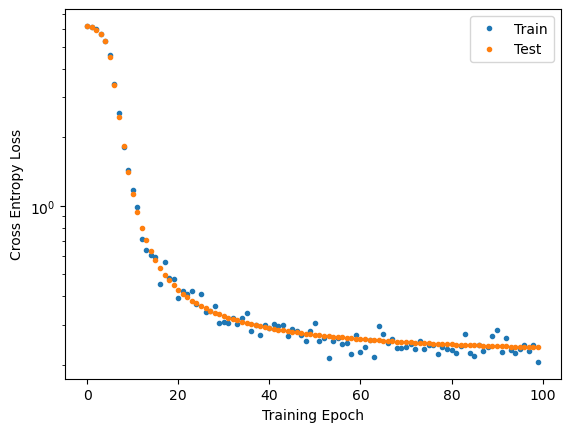

In [20]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

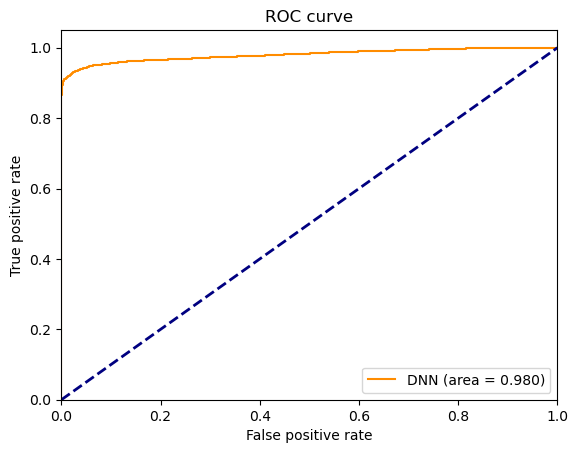

In [21]:
net.eval() # configure the model for evaluation (testing)
y_pred_test = torch.prod(net(x_test_tensor),dim=1).detach().cpu()
y_pred_train= torch.prod(net(x_train_tensor),dim=1).detach().cpu()

LearningCutsUtils.LearningCutsUtils.make_ROC_curve(y_test, y_pred_test)

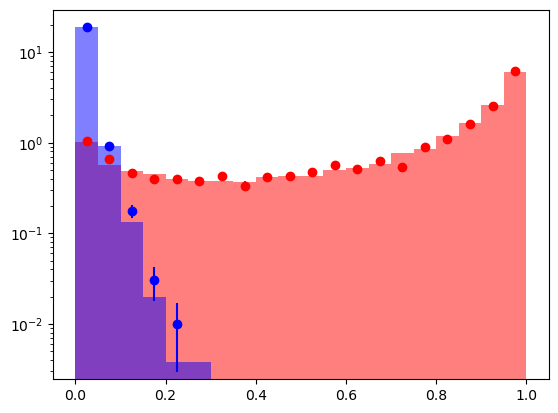

In [22]:
LearningCutsUtils.LearningCutsUtils.plot_classifier_output(y_train, y_pred_train,y_test, y_pred_test)

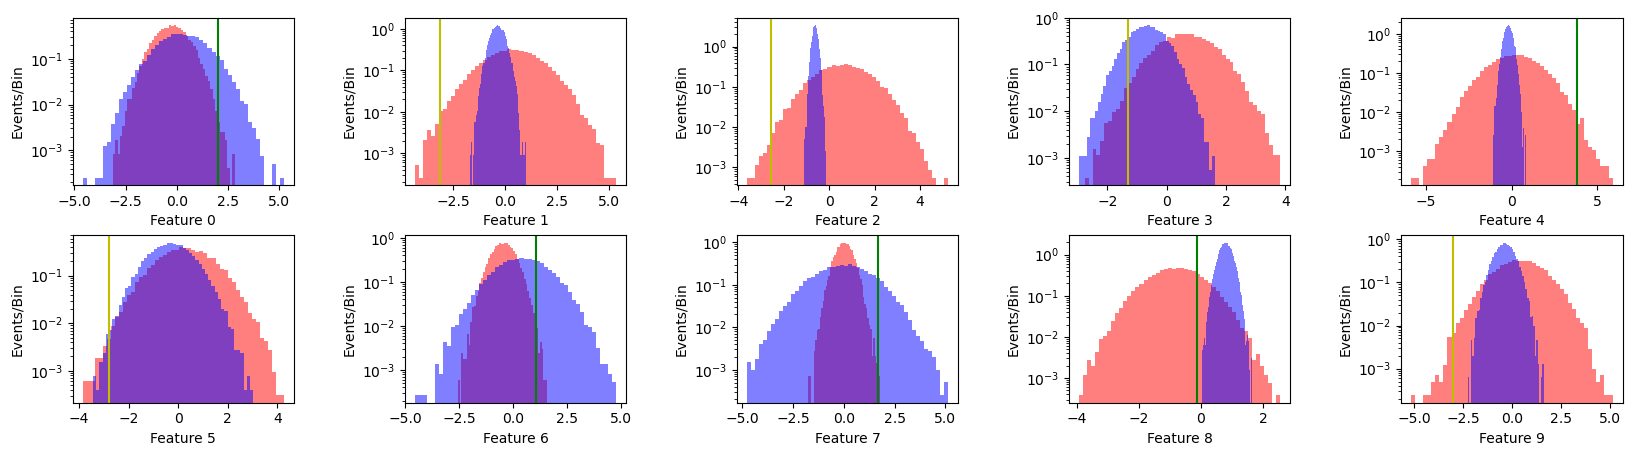

In [23]:
# Distributions after scaling

fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

biases=net[0].bias.detach().numpy()
weights=net[0].weight.detach().numpy()
scaled_cuts=-biases/weights

x_signal_scaled=sc.transform(x_signal)
x_backgr_scaled=sc.transform(x_backgr)

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    if weights[b] < 0:
        ax.axvline(x = scaled_cuts[b], color='g') # cut is "less than"
    else:
        ax.axvline(x = scaled_cuts[b], color='y') # cut is "greater than"

In [24]:
num_pass_test=0.
num_bg_pass_test=0.
test_outputs = net[0](x_test_tensor).detach().cpu()
trues=torch.tensor(m*[True])
for i in range(len(test_outputs)):

    tt=torch.zeros(m)
    t=torch.gt(test_outputs[i],tt)

    if torch.equal(t,trues) and y_test[i]==1.:
        num_pass_test+=1
    elif torch.equal(t,trues) and y_test[i]!=1.:
        num_bg_pass_test+=1.
    

effic_test = num_pass_test / np.sum(y_test)
print(f"Signal Efficiency with net outputs: {100*effic_test:4.1f}%")

bg_effic_test = num_bg_pass_test / np.sum(1.-y_test)
print(f"Background Efficiency with net outputs: {100*bg_effic_test:6.5f}%")

Signal Efficiency with net outputs: 76.8%
Background Efficiency with net outputs: 0.00000%
